# Principal Components Analysis (PCA)

Peter Ralph

https://uodsci.github.io/dsci345

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd

rng = np.random.default_rng(1234)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\sd` in LaTeX below.

# When there's lots of variables

Suppose we have a bunch of data, like
$$ 
\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1k} \\
X_{21} & X_{22} & \cdots & X_{2k}\\
\vdots & \vdots & \ddots & \vdots \\
X_{n1} & \cdots & \cdots &X_{nk}
\end{bmatrix}
$$
where
$$\begin{aligned}
    X_{i \cdot} &= \text{(one observation)} \\
    X_{\cdot j} &= \text{(one variable)} .
\end{aligned}$$

How do we "look" at it?
First, we look at all the variables separately and in pairs.
... what next?

One way to look at this is that we have $n$ points in $\mathbb{R}^k$.

Then, PCA answers the question:
"What are the most important axes of variation
(of the data in $\mathbb{R}^k$)?"

Let's start with an example.

# Manatee Morphometrics

Manatees come in different shapes and sizes.
In our morphometric study of manatees,
we will take 20 different measurements from each of 250 manatees:
head length, tail width, nostril spacing, belly diamter, etcetera.
Here's a rough model of the data:

- some manatees are bigger than others; this underlying "size" affects all variables roughly equally
- there are average shape differences between sexes in some variables

So, we'll:

1. choose the mean female minus male difference for each variable
2. generate the sex and relative size of each manatee
3. generate all measurements from independent Normals, adjusted by sex and size

In [3]:
k = 20
n = 250
sexes = np.array(['f', 'm'])[1 * (rng.random(size=n) < 0.5)]
sizes = rng.normal(loc=1.0, scale=0.2, size=n)

mean_measurements = rng.gamma(shape=10, scale=10, size=k)
sex_diffs = np.sort(rng.normal(loc=10, scale=25, size=k)) # female minus male
sd_measurements = 20

X = rng.normal(loc=mean_measurements, scale=sd_measurements, size=(n, k))
X[sexes == 'f', :] += sex_diffs
X *= sizes[:, np.newaxis]

What'd we just do?
$$\begin{aligned}
    \mu_j &= \text{(mean measurement for variable $j$)} \\
    d_j &= \text{(mean female minus male difference for variable $j$)} \\
    S_i &= \text{("size" of manatee $i$)} \\
        &\sim \text{Normal}(\text{mean}=1, \text{sd}=0.1) \\
    F_i &= \begin{cases}
        1 \qquad &\text{if manatee $i$ is female} \\
        0 \qquad &\text{otherwise}
    \end{cases} \\
    \epsilon_{ij} &\sim \text{Normal}(0, \sigma) \\
    X_{ij} &= \text{(measurement $j$ for manatee $i$)} \\
        &= S_i \left( \mu_j + d_j F_i + \epsilon_{ij} \right) .
\end{aligned}$$

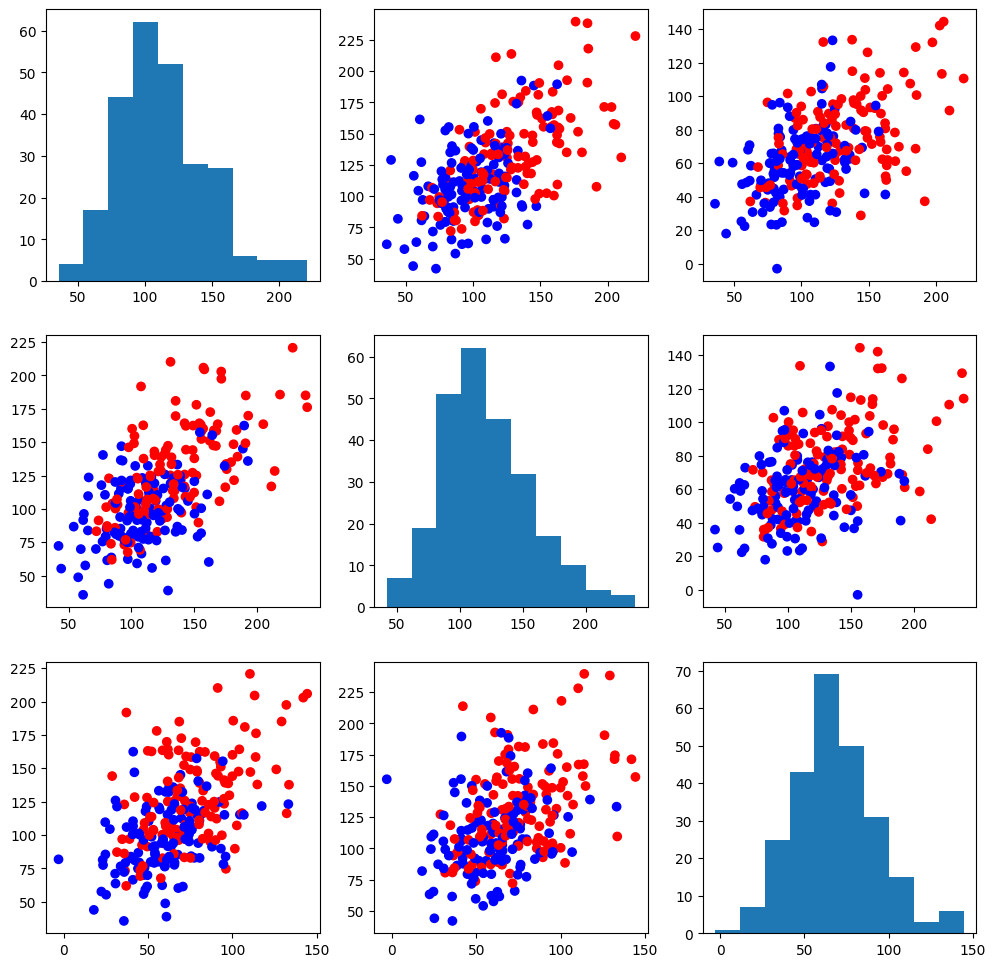

In [3]:
# PCA fig 1
colors = np.array(['r', 'b'])[1 * (sexes == 'f')]
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        if i == j:
            ax.hist(X[:,i])
        else:
            ax.scatter(X[:,i], X[:,j], c=colors)

First, we do PCA *(explanation later)*:

In [4]:
covmat = np.cov(X.T)
evals, evecs = np.linalg.eig(covmat)
eord = np.argsort(evals)[::-1]
evals = evals[eord]
evecs = evecs[:,eord]
pcs = X.dot(evecs)

## Scree plot

<div style="float: right; width: 40%;">
<img src="images/scree.png" alt="scree slope in the mountains">
</div>


Larger eigenvalues are more important (in a way we'll explain later).
It turns out that the eigenvalue, squared, is proportional to
"the percent variation explained" by the corresponding PC.
Plotting these is referred as a "scree plot".

**Scree plot:**

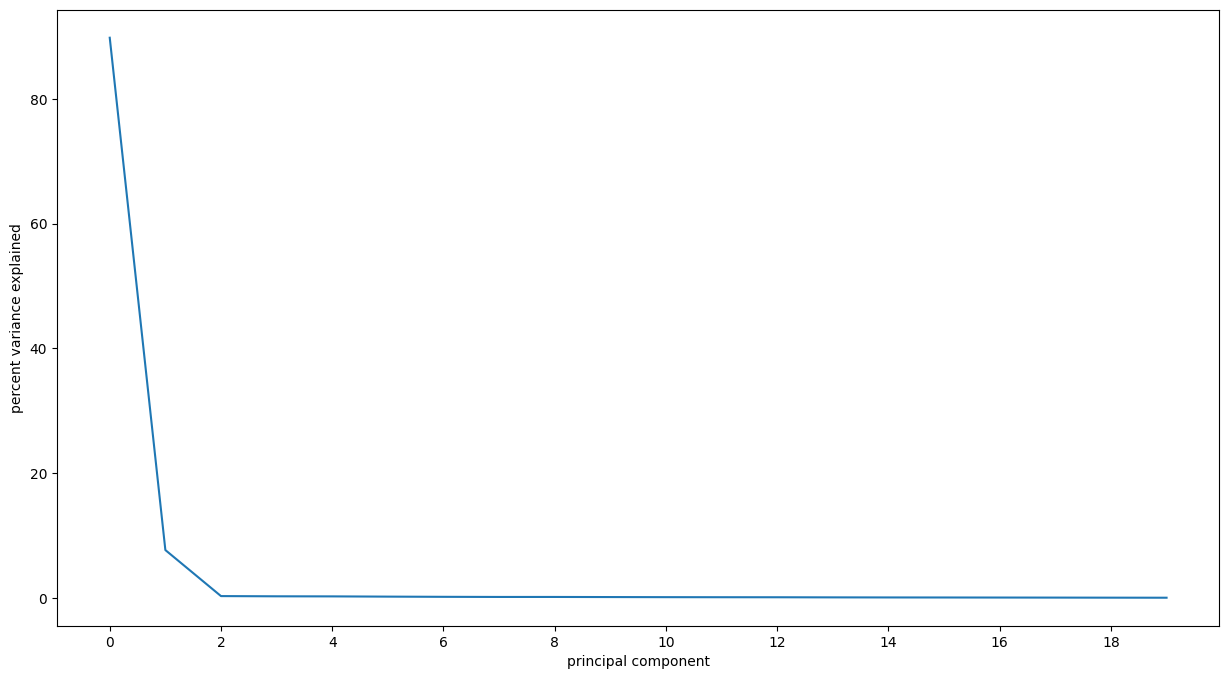

In [5]:
# PCA fig 2
perc_var = 100 * evals**2 / np.sum(evals**2)
plt.plot(perc_var)
plt.xlabel("principal component")
plt.ylabel("percent variance explained")
plt.xticks(np.arange(0, 20, 2));

## Manatees in PC space

Here is a plot of the (projections of each manatee on to the)
first two principal components,
colored by sex of the manatee.

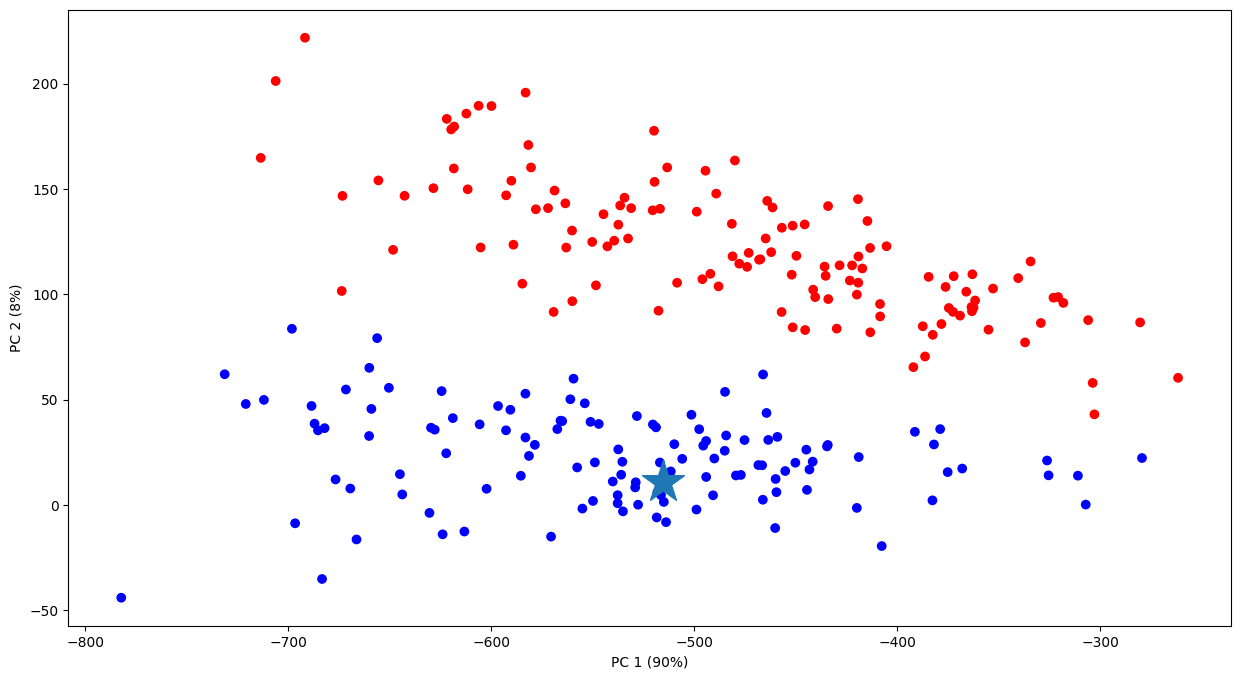

In [6]:
# PCA fig 3
plt.scatter(pcs[:,0], pcs[:,1], c=np.array(['red', 'blue'])[1*(sexes == 'f')])
plt.scatter(pcs[0,0], pcs[0,1], marker="*", s=1000) # manatee number 0
plt.xlabel(f"PC 1 ({perc_var[0]:.0f}%)"); plt.ylabel(f"PC 2 ({perc_var[1]:.0f}%)");

# "PC1 is size"

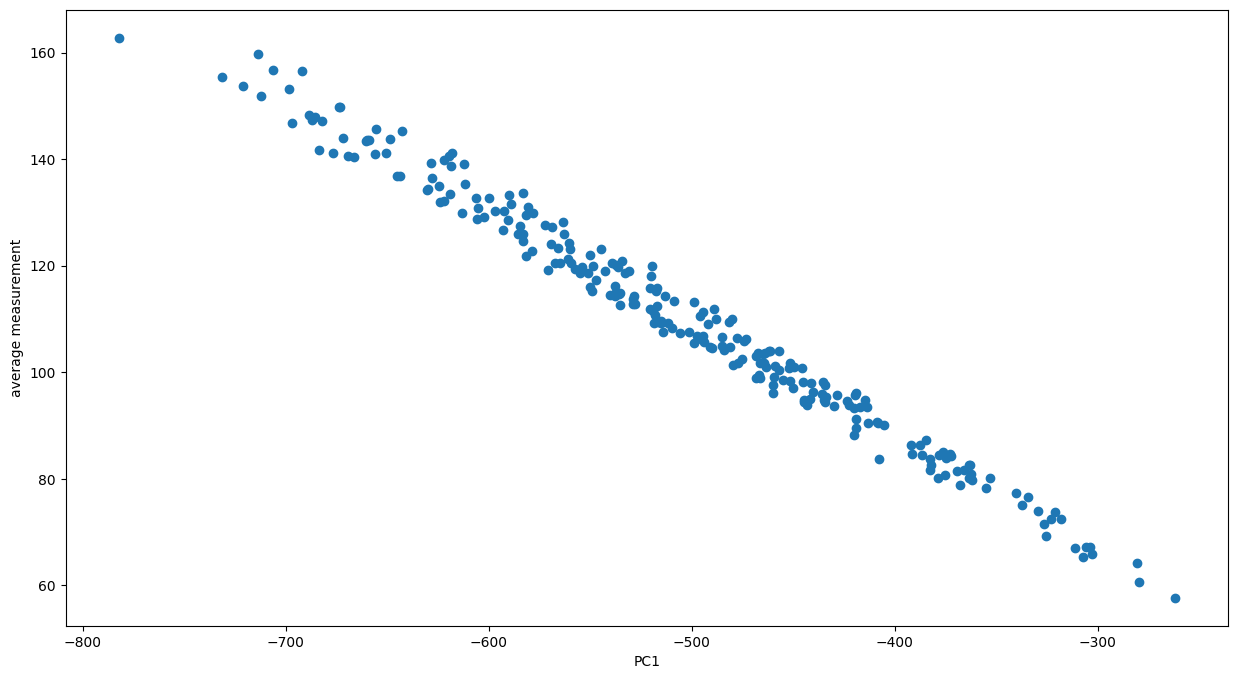

In [7]:
# PCA fig 4
plt.scatter(pcs[:,0], np.mean(X, axis=1))
plt.xlabel("PC1"); plt.ylabel("average measurement");

## How variables contribute to each PC

These are called the "loadings":

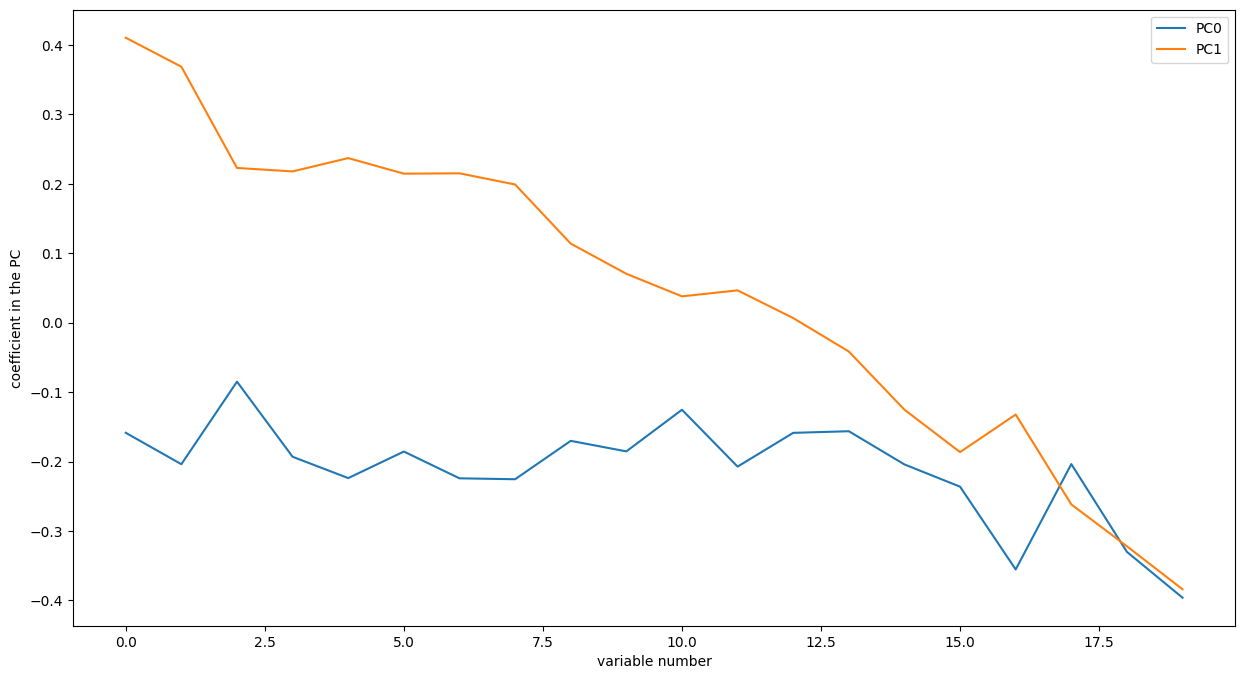

In [8]:
# PCA fig 5
for k in np.arange(2):
    plt.plot(evecs[:, k], label=f"PC{k}")

plt.xlabel("variable number")
plt.ylabel("coefficient in the PC")
plt.legend();

# What's happening: the math

## The Principal Components

Suppose that $X$ is $k$-dimensional with $\E[X] = 0$ and
$$ \cov[X] = C .$$

Say we want to combine a bunch of these variables
into a new, composite variable:
take coefficients $a = (a_1, \ldots, a_{k})$
and define $Y = a \cdot X = \sum_{i=1}^k a_i X_i$.

What is $\var[Y]$?

Since $\E[Y] = 0$,
$$\begin{aligned}
    \var[Y] &= \E[Y^2] \\
        &= \E\left[ \left(\sum_{i=1}^k a_i X_i \right)^2 \right] \\
        &= \E\left[ \sum_{i=1}^k \sum_{j=1}^k a_i a_j X_i X_j \right] \\
        &= \sum_{i=1}^k \sum_{j=1}^k a_i a_j \E\left[ X_i X_j \right] \\
        &= \sum_{i=1}^k \sum_{j=1}^k a_i a_j C_{ij} \\
        &= a^T C a .
\end{aligned}$$

*Which choice of coefficients, $a$, maximizes the variance of $Y = a \cdot X$?*

The *top eigenvector* of the covariance matrix, $C$.

*Which choice of coefficients $b$ maximizes the variance of $Z = b \cdot X$,
for $b$ such that $\cov[Y, Z] = 0$?*

The second eigenvector of the covariance matrix.

*Linear algebra fact:*
If $\lambda_i$ and $v_i$ are the $i^\text{th}$ eigenvalue and eigenvector of $C$,
with $\|v_i\| = 1$,
then
$$
    C = \sum_{i=1}^k \lambda_i v_i v_i^T .
$$
Furthermore, since $C$ is symmetric, $v_i \cdot v_j = \delta_{ij}$, and
$$
    \sum_{ij} C_{ij}^2 = \sum_i \lambda_i^2 .
$$

*Said another way:*
If we change into the basis given by the eigenvectors,
$C$ is diagonal,
and this change of basis is *orthogonal* (i.e., it preserves distances).

**Terminology:**

- $v_i \cdot X$: the $i^\text{th}$ principal component, PC$i$
- $v_i$: the *loadings* of PC$i$ on each variable
- $\lambda_i^2$: the amount of *variance explained* by PC$i$

So, what'd we do?

Find the covariance matrix:
```
covmat = np.cov(X.T)
```

Get the eigenvalues and eigenvectors:
```
evals, evecs = np.linalg.eig(covmat)
```

Sort them by size of eigenvalue:
```
eord = np.argsort(evals)[::-1]
evals = evals[eord]
evecs = evecs[:,eord]
```

Change the data matrix into the basis given by the eigenvectors:
```
pcs = X.dot(evecs)
```

Find the percent variance explained by each PC:
```
perc_var = 100 * evals**2 / np.sum(evals**2)
```

# Example: text analysis

In [`data/passages.txt`](data/passages.txt)
we have a number of short passages from a few different books.

Can we identify the authors of each passage?

The true sources of the passages are in [data/passage_sources.tsv](data/passage_sources.tsv).

## Turn the data into a matrix

In [9]:
from collections import defaultdict

pfile = open("data/passages.txt", "r")
passages = pfile.read().split("\n")[:-1]
sources = pd.read_table("data/passage_sources.tsv")
words = np.unique(" ".join(passages).split(" "))[1:]
def tabwords(x, words):
    d = defaultdict(int)
    for w in x.split(" "):
        d[w] += 1
    out = np.array([d[w] for w in words])
    return out

wordmat = np.array([tabwords(x, words) for x in passages])

In [10]:
passages[1]

'elinor encouraged her as much as possible to talk of what she felt and before breakfast was ready they had gone through the subject again and again and with the same steady conviction and affectionate counsel on elinors side the same impetuous feelings and varying opinions on mariannes as before sometimes she could believe willoughby to be as unfortunate and as innocent as herself and at others lost every consolation in the impossibility of acquitting him at one moment she was absolutely indifferent to the observation of all the world at another she would seclude herself from it for ever and at a third could resist it with energy in one thing however she was uniform when it came to the point in avoiding where it was possible the presence of mrs jennings and in a determined silence when obliged to endure it jenningss entering into her sorrows with any compassion her kindness is not sympathy her goodnature is not tenderness all that she wants is gossip and she only likes me now because 

In [11]:
for w, x in zip(words[:20], wordmat[:20,:].T):
    print(f"{w}: {x}")

a: [15  9 12  8  7  7  5 12  8  3 18 12 13 11  2  2 12 14 11 14]
aback: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abaft: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abandon: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abandoned: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abandonment: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abased: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abasement: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abashed: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abate: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abated: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abatement: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abating: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abbeyland: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abbreviate: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abbreviation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abeam: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abednego: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abhor: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
abhorred

This time we "do PCA" by finding the "singular value decomposition"
(SVD) of the data matrix,
because `scipy.sparse.linalg.svds` lets us *only*
find the PCs we're interested in:
finding *all* would take waaaay too long.

In [20]:
from scipy.sparse.linalg import svds
# center and scale the data
x = wordmat - np.mean(wordmat, axis=1)[:,np.newaxis]
x /= np.std(x, axis=1)[:, np.newaxis]
pcs, evals, evecs = svds(x, k=3)
eord = np.argsort(evals)[::-1]
evals = evals[eord]
evecs = evecs[eord,:]
pcs = pcs[:,eord]

## The loadings

In [13]:
loadings = pd.DataFrame(evecs.T, columns=[f"PC{k}" for k in range(1,4)], index=words)
loadings

,PC1,PC2,PC3
a,0.200405,-0.037541,-0.055637
aback,-0.000536,-0.000239,0.000244
abaft,-0.000554,-0.000167,0.000109
abandon,-0.000514,-0.000292,-0.000012
abandoned,-0.000394,-0.000976,0.000132
...,...,...,...
zephyr,-0.000553,-0.000176,0.000067
zodiac,-0.000460,-0.000522,-0.000393
zone,-0.000406,-0.000765,-0.000035
zones,-0.000505,-0.000423,-0.000012


## The PCs

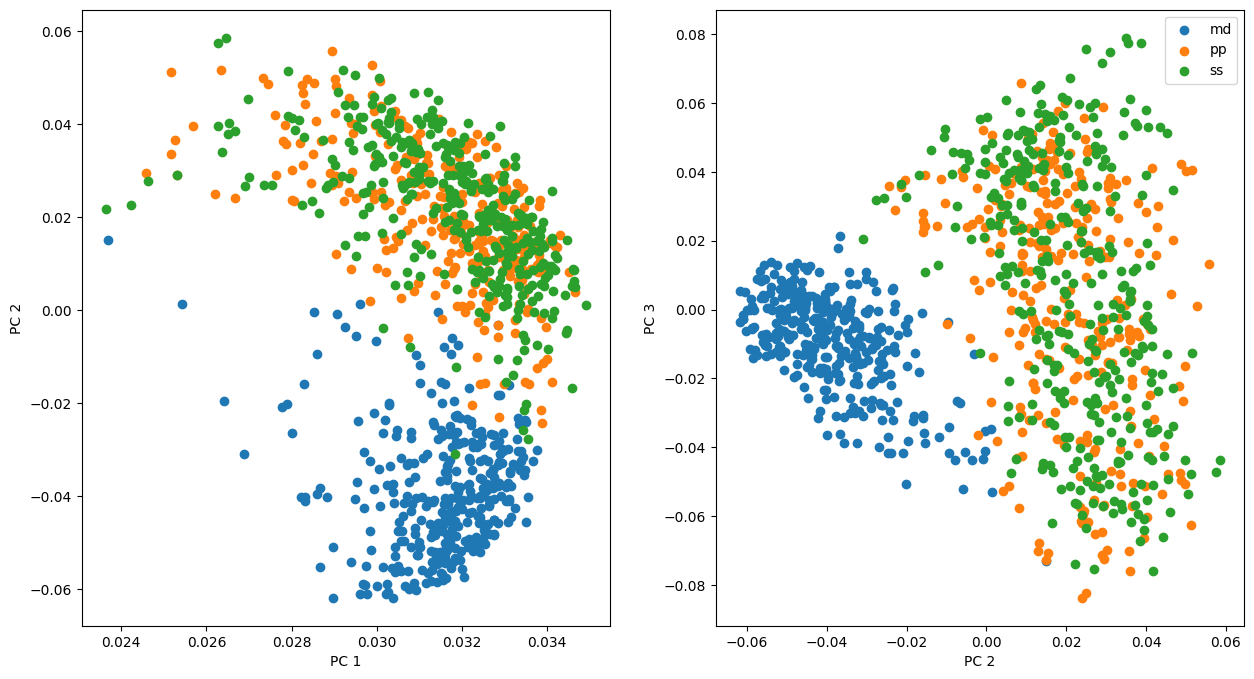

In [14]:
# PCA fig 6 & 7
fig, (ax0, ax1) = plt.subplots(1, 2)
for s in np.unique(sources['source']):
    ax0.scatter(pcs[sources['source'] == s,0], pcs[sources['source'] == s,1])
    ax1.scatter(pcs[sources['source'] == s,1], pcs[sources['source'] == s,2], label=s)

ax0.set_xlabel("PC 1"); ax0.set_ylabel("PC 2")
ax1.set_xlabel("PC 2"); ax1.set_ylabel("PC 3")
ax1.legend();

## PC 1 is length

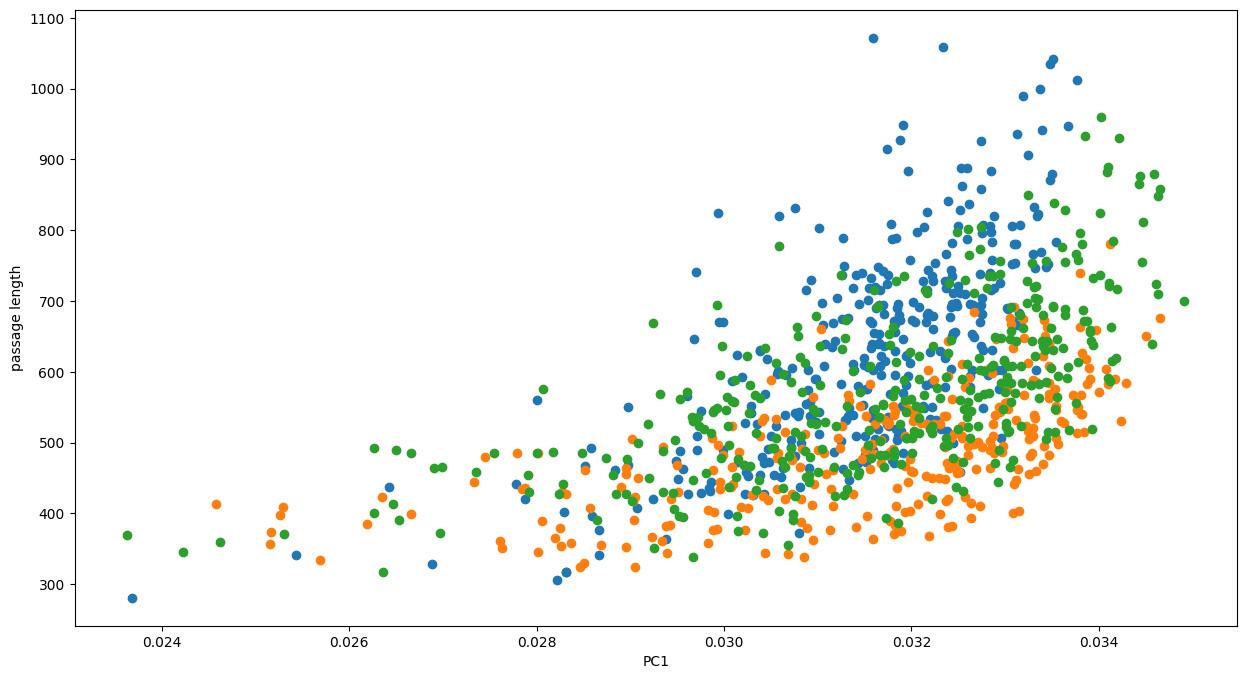

In [15]:
# PCA fig 8
lengths = np.sum(wordmat, axis=1)
for s in np.unique(sources['source']):
    plt.scatter(
        pcs[sources['source'] == s, 0],
        lengths[sources['source'] == s]
    )
plt.xlabel("PC1"); plt.ylabel("passage length");

## PC2 is book

In [21]:
loadings.sort_values("PC2").head(20)

,PC1,PC2,PC3
the,0.523547,-0.652591,0.022868
whale,0.014152,-0.069795,-0.026534
in,0.196969,-0.053266,-0.005499
this,0.047997,-0.042451,-0.052062
a,0.200405,-0.037541,-0.055637
like,0.014690,-0.035441,-0.017307
upon,0.016007,-0.035191,-0.028701
ahab,0.006510,-0.032928,-0.007920
sea,0.006046,-0.031019,-0.006752
ship,0.005879,-0.028600,-0.006917


In [17]:
loadings.sort_values("PC2 ").tail(20)

,PC1,PC2,PC3
me,0.030992,0.046881,-0.137308
would,0.038035,0.047110,-0.013667
he,0.101428,0.047711,-0.022485
elinor,0.019032,0.050489,0.023545
very,0.033219,0.052090,-0.018889
your,0.025251,0.054792,-0.116548
for,0.100339,0.057560,-0.043023
could,0.038412,0.070246,0.058351
it,0.130834,0.071298,-0.134508
have,0.060876,0.078142,-0.118018


## PC3?

In [18]:
loadings.sort_values("PC3").head(20)

,PC1,PC2,PC3
i,0.132836,0.256586,-0.532524
you,0.076411,0.150797,-0.331023
my,0.047833,0.089361,-0.194434
is,0.065981,-0.015494,-0.170012
me,0.030992,0.046881,-0.137308
it,0.130834,0.071298,-0.134508
have,0.060876,0.078142,-0.118018
your,0.025251,0.054792,-0.116548
that,0.142322,0.020713,-0.103028
be,0.093912,0.131226,-0.075934


In [19]:
loadings.sort_values("PC3").tail(20)

,PC1,PC2,PC3
mother,0.010312,0.025910,0.021928
them,0.037627,0.026889,0.022182
the,0.523547,-0.652591,0.022868
elinor,0.019032,0.050489,0.023545
they,0.045059,0.018149,0.024460
every,0.022388,0.019543,0.028844
mrs,0.012199,0.028403,0.031719
marianne,0.013762,0.034782,0.033626
which,0.049184,0.029560,0.034382
by,0.064756,0.005060,0.034632
